In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import matplotlib.patches as mpatches

%pip install igraph leidenalg

# Load the preprocessed dataset
octo_brain = sc.read_h5ad('octo_brain_preprocessed.h5ad')

# Check available clusters
print(octo_brain.obs['leiden'].unique()) # 20 clusters

print(octo_brain) # 58863 cells and 2,000 highly variable genes


Note: you may need to restart the kernel to use updated packages.
['6', '11', '8', '0', '2', ..., '18', '19', '10', '13', '16']
Length: 20
Categories (20, object): ['0', '1', '2', '3', ..., '16', '17', '18', '19']
AnnData object with n_obs × n_vars = 57042 × 2000
    obs: 'Sample', 'decontX_contamination', 'nFeature_RNA', 'nCount_RNA', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'gene_ids', 'highly_variable'
    uns: 'Sample_colors', 'X_name', 'hvg', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [2]:
# Load homologs file
homo_map = pd.read_csv("final_ob_hu.txt", sep="\t")
homo_map = dict(zip(homo_map["Octopus_Gene"], homo_map["Human_Homolog"]))
# print(homo_map)


In [3]:
# remove ".g" at the end of octo_brain
octo_brain.var_names = octo_brain.var_names.str.replace(r"\.g$", "", regex=True)
octo_brain.raw = None # set raw = None so scanpy uses the new octo_brain which is without ".g"

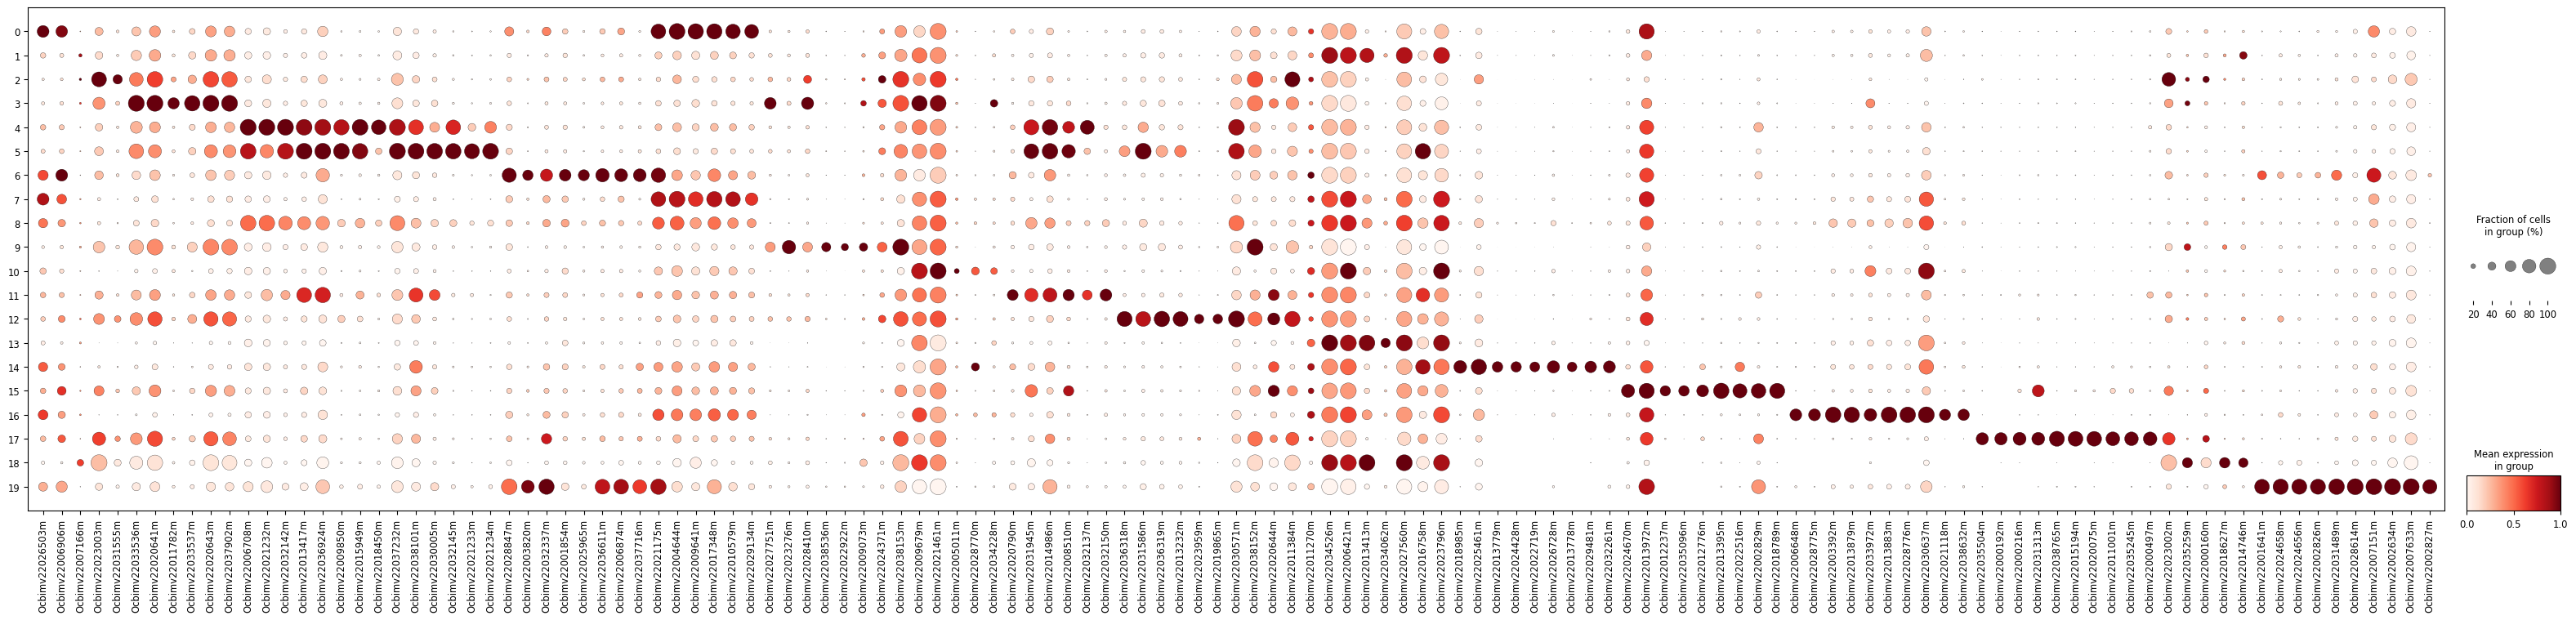

In [4]:
# Rank genes based on differential expression across clusters
# This function identifies marker genes for each Leiden cluster (identified via community detection).
# Uses the Wilcoxon rank-sum test to compare expression levels of genes between clusters.


sc.tl.rank_genes_groups(octo_brain, groupby="leiden", method="wilcoxon")

gene_cluster_map = {}  # Dictionary to store gene-to-cluster mapping # Stores a mapping between a gene and the most enriched cluster it belongs to.
top_genes_df = pd.DataFrame() #Empty DataFrame that will store top 10 genes per cluster.

# Iterate over each Leiden cluster to extract top marker genes
for cluster in octo_brain.obs["leiden"].unique():
    # Extract top 10 genes per cluster
    top_genes = sc.get.rank_genes_groups_df(octo_brain, group=cluster).head(10)
    top_genes_df[cluster] = top_genes["names"].values
    
    # Store the most enriched cluster for each gene
    for gene in top_genes["names"]:
        gene_cluster_map[gene] = cluster  # Assign gene to this cluster

# Convert to DataFrame and sort genes by cluster
gene_cluster_df = pd.DataFrame(list(gene_cluster_map.items()), columns=["Gene", "Cluster"])
gene_cluster_df["Cluster"] = gene_cluster_df["Cluster"].astype(int)  # Convert to numeric for sorting
gene_cluster_df = gene_cluster_df.sort_values("Cluster")  # Sort by cluster ID

# Get sorted gene list
sorted_genes = gene_cluster_df["Gene"].values.tolist()
# print(sorted_genes)
sorted_genes = list(dict.fromkeys(gene_cluster_df["Gene"].values))
# print(sorted_genes)

# Plot with sorted genes
sc.pl.dotplot(octo_brain, 
              var_names=sorted_genes,  # Reordered gene list
              groupby="leiden", 
              standard_scale="var",
              cmap="Reds",
              figsize=(40, 8))

In [5]:
# Map homologs for all genes in `octo_brain.var_names`
octo_brain.var["human_homolog"] = octo_brain.var_names.map(homo_map).fillna('No_homolog')

# Count genes with and without homologs
num_homologs = (octo_brain.var["human_homolog"] != 'No_homolog').sum()
num_no_homolog = (octo_brain.var["human_homolog"] == 'No_homolog').sum()
print(f"Genes with human homologs: {num_homologs}, Without homologs: {num_no_homolog}")

print(octo_brain.var.columns)  # List available columns in .var

Genes with human homologs: 931, Without homologs: 1069
Index(['gene_ids', 'highly_variable', 'human_homolog'], dtype='object')


/var/folders/3s/_sl82dcj1b11lhf0rks5_pvc0000gn/T/ipykernel_17189/3998228579.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  octo_brain_hu = octo_brain_hu.groupby(octo_brain.obs["leiden"]).mean()  # Average per cluster


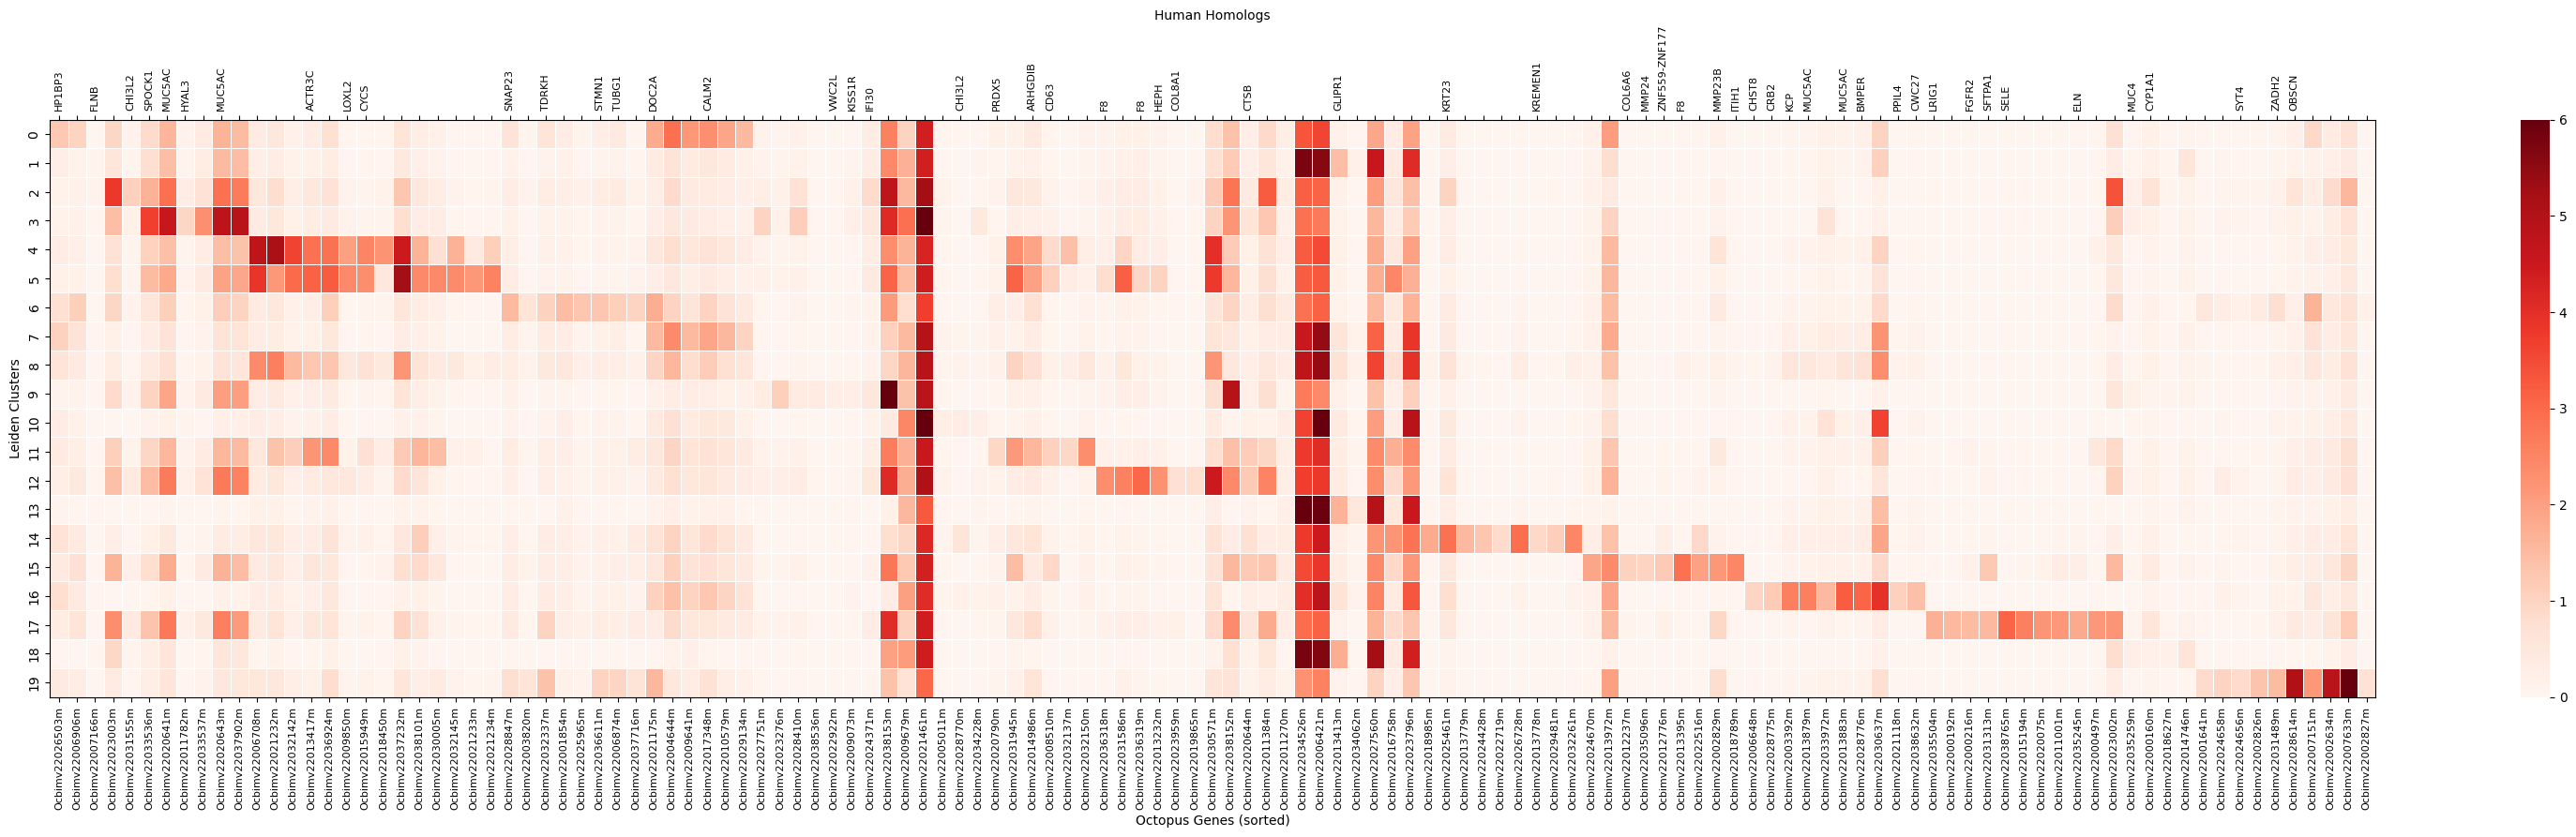

In [6]:
# get human homolog for genes
octo_brain_hu = octo_brain.to_df()[sorted_genes]  # Extract gene expression for selected genes
octo_brain_hu = octo_brain_hu.groupby(octo_brain.obs["leiden"]).mean()  # Average per cluster

# Get human homologs
hu_homo_labels = octo_brain.var.loc[sorted_genes, 'human_homolog'].tolist()

fig, ax = plt.subplots(figsize=(40, 8))
sns.heatmap(octo_brain_hu, cmap="Reds", linewidths=0.5, ax=ax, vmax=6)

# Format bottom x-axis (Octopus genes)
ax.set_xticks(np.arange(len(sorted_genes)) + 0.5)
ax.set_xticklabels(sorted_genes, rotation=90, fontsize=8)

# Add a second x-axis for human homologs
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())  # Sync with bottom axis
ax_top.set_xticks(np.arange(len(sorted_genes)) + 0.5)
ax_top.set_xticklabels(hu_homo_labels, rotation=90, fontsize=8)

# Hide "No_Human_Homolog" labels
for tick, label in zip(ax_top.get_xticks(), ax_top.get_xticklabels()):
    if label.get_text() == "No_homolog":
        label.set_visible(False)  # Hide tick labels that are non-homologs

# Set labels
ax.set_xlabel("Octopus Genes (sorted)")
ax.set_ylabel("Leiden Clusters")
ax_top.set_xlabel("Human Homologs")

plt.show()

In [7]:
# Sort clusters before processing
sorted_clusters = sorted(np.unique(octo_brain.obs["leiden"]).astype(int))  # Convert to integers before sorting

# Initialize list
top_60_gene = []

# Process clusters in sorted order
for cluster in sorted_clusters:
    try:
        top_genes = sc.get.rank_genes_groups_df(octo_brain, group=str(cluster)).head(60)
        top_genes = top_genes["names"].tolist()
        
        top_gene_hu = octo_brain.var.loc[top_genes, 'human_homolog'].tolist()

        for gene, homolog in zip(top_genes, top_gene_hu):
            top_60_gene.append({"Cluster": cluster, "Octopus Gene": gene, "Human Homolog": homolog})
    
    except Exception as e:
        print(f"Error processing cluster {cluster}: {e}")

# Convert to DataFrame
top_60_gene = pd.DataFrame(top_60_gene)

# Save as CSV (already sorted)
top_60_gene.to_csv("octo_brain_homologs_list(top 60 genes).csv", index=False)

/var/folders/3s/_sl82dcj1b11lhf0rks5_pvc0000gn/T/ipykernel_17189/3843592102.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_exp = octo_brain.to_df()[valid_genes].groupby(octo_brain.obs['leiden']).mean()


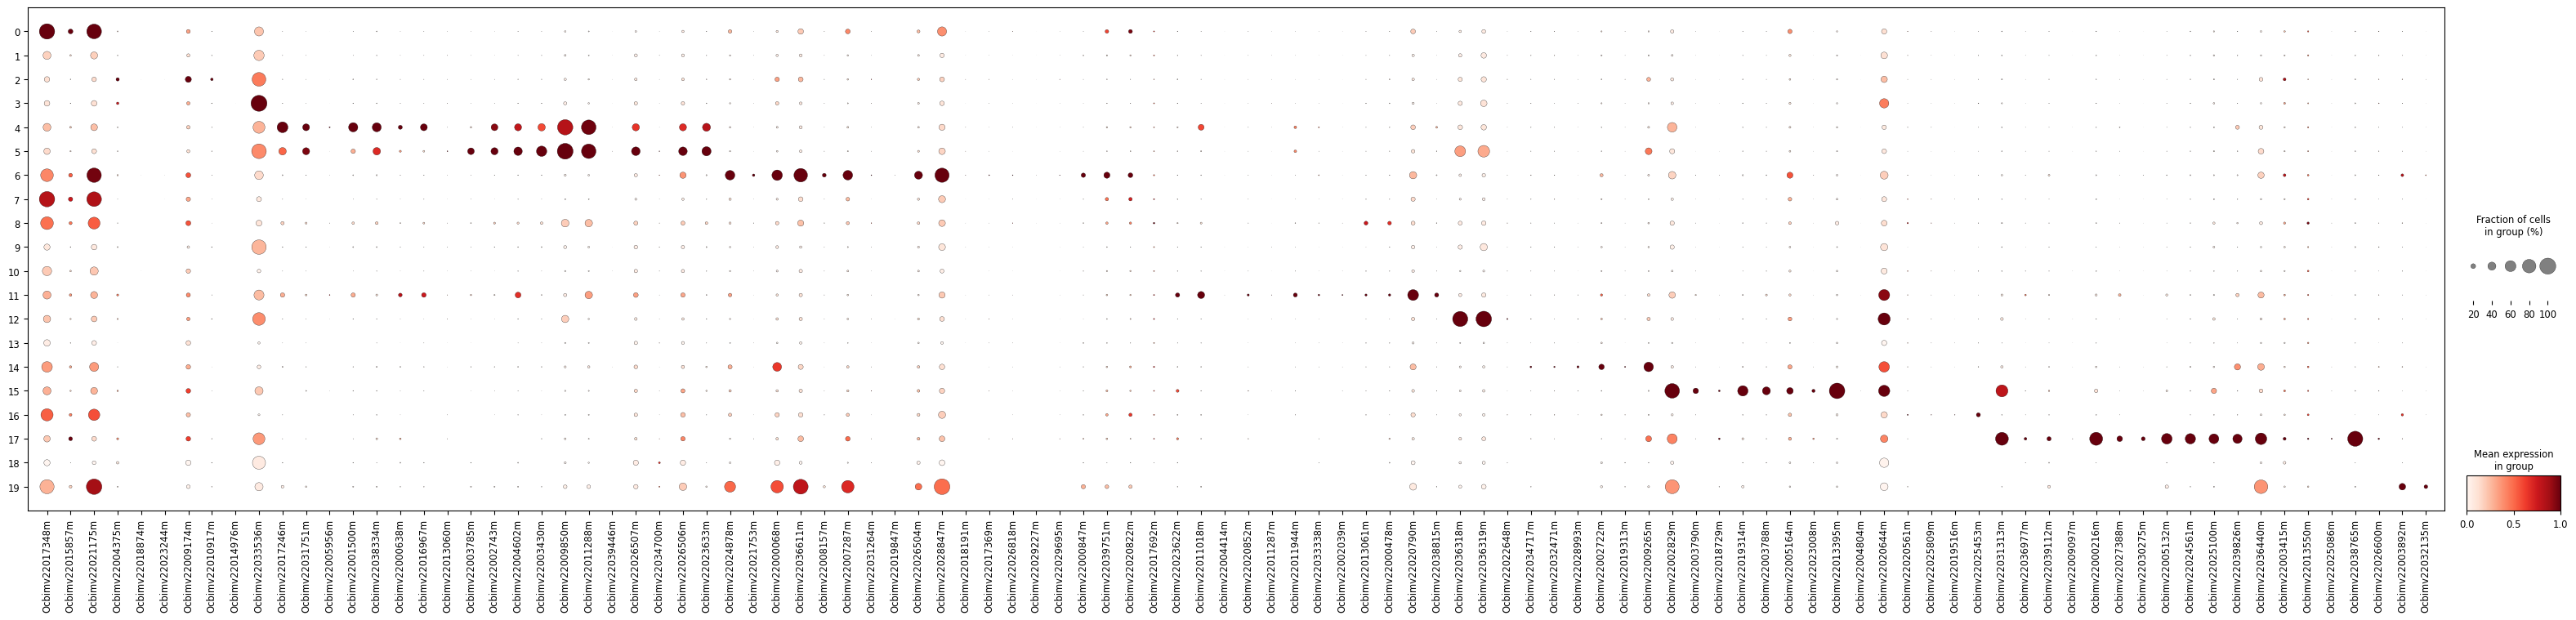

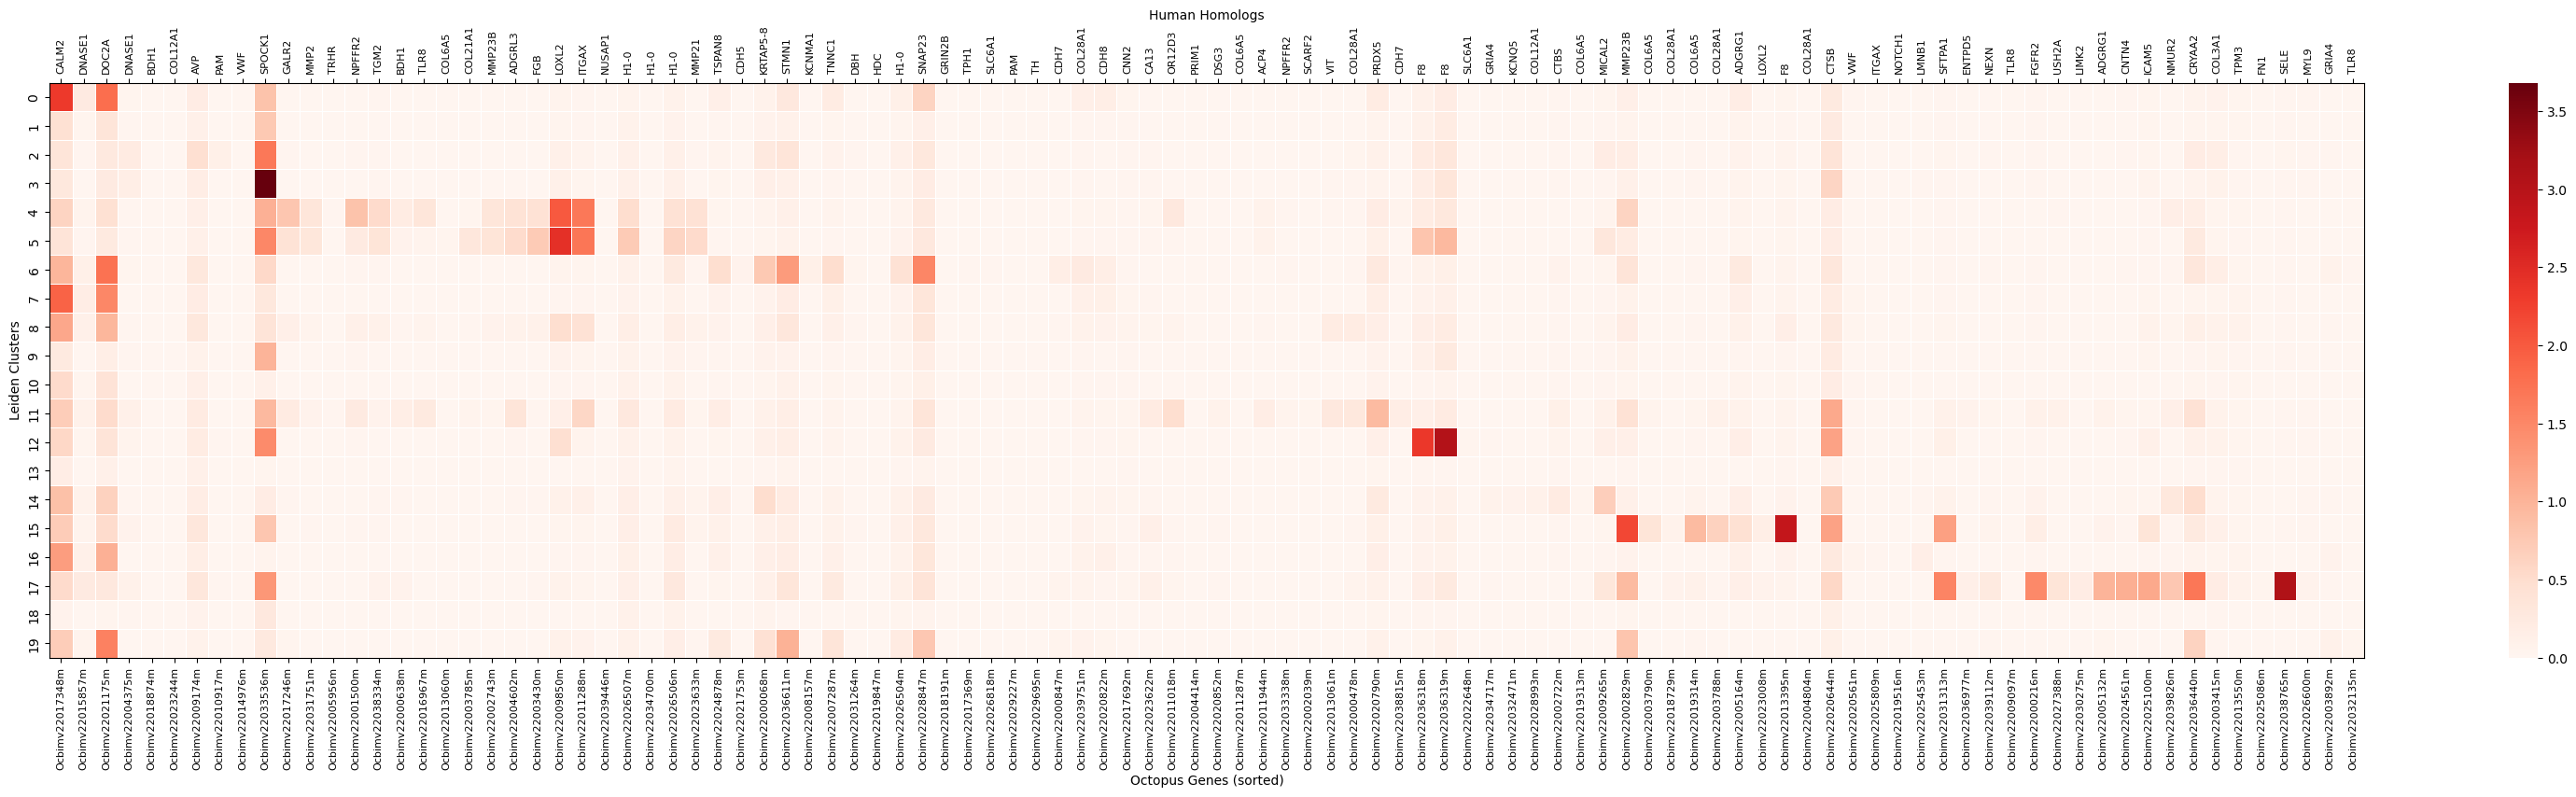

In [8]:
# Finer plot of marker genes for annotation
marker_gene_list = list(set([
    # Neurotransmitter related #
    "SLC32A1", "SLC6A1", "GABRB2", "GABRB3", # GABAergic
    "SLC6A5", # Glycinergic
    "GRIA2", "GRIA4", "GRIN2B", "GRIK2", "SLC2A8", # Glutamatergic
    "CHRNA1", "CHRNA7", "CHRNA10", "CHRM5", "ACHE", "CHRNA7", "CHRNB2", # cholinergic
    "TH",# dopaminergic
    "TPH1", # serotonergic
    "TH", "DBH", # norepinephrin & epinephrin
    "HDC", "HRH2", "HRH4", # histamine
    "PTH2R", "NMUR2", "NPFFR2", "GALR2", "TRHR", "AVP", # unclustered

    "SCN2A", "GABRB3", "DOC2A", "SYN1", "FSTL5", "RDH11",   # Amacrine-like
    "NOTCH1", "TNC", "FN1", "HSPB1", "PRDX1", "NINL", "LMNB1", "ERO1A", "MAT1A", "COL12A1", "THBS2", # basal epithelium 
    "FGFR2", "CRYAA2", "DSG3", "PRDX5", "TGM2", # corneal epithelium 
    "BEST2", "AQP4", "CHRM5", "PRDX5", "BDH1", "PLIGLIPR1N5", "CLK1", "USH2A", "GSTA1", "GSTM1", "SGK3", "KRT19", "CCDC9", # Iris/lentigenic epithelium (pigmented & lens-associated)
    "GABRB3", "GRIK2", "KCNQ5", "SCN2A", "CABP4", "PLCB2", # bipolar (can express either Gluta/GABA receptors)
    "MYL9", "ITGB1", "COL1A1", "COL3A1", "RYR1", "MYH6", "CNN2", "TPM3", "COL3A1", "CKB", "SVIL", "FSCN3", "MMP21", "MMP23B", "SPOCK1", # contractile
    "ITGAX", "ITGB1", "LGALS3", # microglia
    "ITGAX", "LGALS3", "CES5A", "TLR8", # leukocyte
    "CABP4", "OPN3", "TRPC6", # photoreceptor
    "VWF", "CDH5", "SELE", "F8", "FGB", # endothelial
    "H1-0", "H2AB1", "H2AZ2", "NUSAP1", "TPX2", "CDC25A", "KIF22", "SMC1A", "SMC1B", "RRM2B", "DUT", "MCM7", "MCM5", "MCM9", "POLD1", "TIMELESS", "GEN1", "STMN1", "MICAL2", "NEXN", # proliferating cells

    "SNAP23", "CDH7", "KCNMA1", "PAM", "DOC2A", "CDK5R2", "PTPRS", "EFNB1", "CDH8", "SCN2A", "LIMK2", "ICAM5", "ADGRG1", "CNTN4", "CALM2", "HPCA", "RHOJ", "LCORL", "ASCL2", "NKX2-8", "FAIM", "NEFH", # neurons
    "MCM7", "MCM5", "MCM9", "POLD1", "TIMELESS", "ORC6", "SLBP", "PRIM1", "PAICS", "DUT", "STMN1", # DNA replication, cell cycle, genome maintenance
    "SMC1A", "SMC1B", "GEN1", # chromosome maintenance
    "ASCL1", "SDF4", # neural progenitor
    "TNNC1", "RYR1", # muscle contraction
    "KRTAP5-8", "COL28A1", "COL6A5", "COL21A1", "DSG3", "LOXL2", "SPOCK1", "MMP21", "MMP23B", "ITGB1", # structural support & ECM remodeling
    "CLK1", # circadian rhythm
    "OR12D3", # olfactory
    "VIT", "CA13", "PRDX5", "ENTPD5", # metabolic
    "DNASE1", "CTSB", "TLR8", "SFTPA1", "SCARF2", "ITGAX", "LGALS3", "CES5A", # immune
    "MMP2", "LOXL2", # wound healing
    "TSPAN8", "ADGRL3", # cell adhesion
    "CTSB", "CTBS", "ACP4", # lysosomal
    "PITPNA", 
]))
    

# convert human genes to octopus gene
human_to_octo = defaultdict(list)
for octo_gene, human_gene in homo_map.items():
    human_to_octo[human_gene].append(octo_gene)


marker_gene_list_octo = []
for human_gene in marker_gene_list:
    if human_gene in human_to_octo:
        marker_gene_list_octo.extend(human_to_octo[human_gene])

# Check which genes exist in the dataset
valid_genes = [gene for gene in marker_gene_list_octo if gene in octo_brain.var_names]

if not valid_genes:
    print("None of the marker genes are present in the dataset")

if valid_genes:
    cluster_exp = octo_brain.to_df()[valid_genes].groupby(octo_brain.obs['leiden']).mean()

    gene_cluster_map = {}
    for gene in valid_genes:
        highest_cluster = cluster_exp[gene].idxmax() # find the cluseter which express that gene the most
        gene_cluster_map[gene] = highest_cluster 
    
    # Convert to DataFrame and sort genes by their most expressed cluster
    gene_cluster_df = pd.DataFrame(list(gene_cluster_map.items()), columns=["Gene", "Cluster"])
    gene_cluster_df["Cluster"] = gene_cluster_df["Cluster"].astype(int)  # Convert cluster to numeric
    gene_cluster_df = gene_cluster_df.sort_values("Cluster")  # Sort genes by their primary cluster

    # **Step 7: Sort genes based on primary cluster**
    sorted_genes = list(gene_cluster_df["Gene"].values)  # Sorted gene list

    # **Step 8: Plot Dot Plot with sorted genes**
    sc.pl.dotplot(octo_brain, 
                  var_names=sorted_genes,  # Reordered gene list
                  groupby="leiden", 
                  standard_scale="var",
                  cmap="Reds",
                  figsize=(40, 8))

    # **Step 9: Retrieve human homologs for sorted genes**
    hu_homo_labels = octo_brain.var.loc[sorted_genes, 'human_homolog'].tolist()

    # **Step 10: Plot Heatmap with human homolog labels**
    fig, ax = plt.subplots(figsize=(40, 8))
    sns.heatmap(cluster_exp[sorted_genes], cmap="Reds", linewidths=0.5, ax=ax)

    # Format bottom x-axis (Octopus genes)
    ax.set_xticks(np.arange(len(sorted_genes)) + 0.5)
    ax.set_xticklabels(sorted_genes, rotation=90, fontsize=8)

    # Add a second x-axis for human homologs
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())  # Sync with bottom axis
    ax_top.set_xticks(np.arange(len(sorted_genes)) + 0.5)
    ax_top.set_xticklabels(hu_homo_labels, rotation=90, fontsize=8)

    # Hide "No_Human_Homolog" labels
    for tick, label in zip(ax_top.get_xticks(), ax_top.get_xticklabels()):
        if label.get_text() == "No_homolog":
            label.set_visible(False)  # Hide tick labels that are non-homologs

    # Set labels
    ax.set_xlabel("Octopus Genes (sorted)")
    ax.set_ylabel("Leiden Clusters")
    ax_top.set_xlabel("Human Homologs")
    
    plt.show()

In [9]:
# Define a function to check and map a list of human genes
def plot_gene_list(human_genes, human_to_octo, octo_brain):
    """
    Maps a list of human genes to octopus genes and generates a dot plot.
    
    Parameters:
    - human_genes: List of human gene names to be mapped.
    - human_to_octo: Dictionary mapping human genes to octopus homologs.
    - octo_brain: AnnData object containing octopus gene expression data.
    """
    
    valid_genes = {}  # Dictionary to store mapped genes (human_gene -> found octo_gene)
    missing_genes = {}  # Dictionary for genes that could not be found in octo_brain.var_names

    for human_gene in human_genes:
        # Ensure gene exists in the mapping dictionary
        oct_names = human_to_octo.get(human_gene, None)

        if oct_names is None:
            print(f"⚠️ Warning: {human_gene} not found in human_to_octo mapping.")
            missing_genes[human_gene] = "No octopus homolog found"
            continue  # Skip to the next gene

        # Ensure oct_names is always a list
        oct_names = [oct_names] if isinstance(oct_names, str) else oct_names

        found_oct_genes = []
        not_found_oct_genes = []

        # Filter valid genes that exist in octo_brain.var_names
        for gene in oct_names:
            if gene in octo_brain.var_names:
                found_oct_genes.append(gene)
            else:
                not_found_oct_genes.append(gene)

        if found_oct_genes:
            valid_genes[human_gene] = found_oct_genes  # Store successfully mapped genes
        if not_found_oct_genes:
            missing_genes[human_gene] = not_found_oct_genes  # Store missing octopus genes

    # Print summary of found and missing genes
    print("\n **Mapped and Found Genes (Plotted):**")
    for human_gene, oct_genes in valid_genes.items():
        print(f"  - {human_gene} → {', '.join(oct_genes)} (Plotted)")

    if missing_genes:
        print("\n⚠️ **Missing or Not Found in octo_brain.var_names:**")
        for human_gene, oct_genes in missing_genes.items():
            if isinstance(oct_genes, list):
                print(f"  - {human_gene} → {', '.join(oct_genes)} (Not Found)")
            else:
                print(f"  - {human_gene} → {oct_genes}")

    # Generate dot plot only if there are valid genes
    if valid_genes:
        sc.pl.dotplot(octo_brain, var_names=[gene for genes in valid_genes.values() for gene in genes], 
                      groupby="leiden", cmap="Reds")
    else:
        print(" No valid genes found in octo_brain.var_names. Skipping plot.")

# Example usage:
human_genes = [
]
plot_gene_list(human_genes, human_to_octo, octo_brain)



 **Mapped and Found Genes (Plotted):**
 No valid genes found in octo_brain.var_names. Skipping plot.


In [10]:
# annotation of cell types

brain_type_dict = {
    "0": "Neuron -1",  
    "1": "Epithelial-like -1", 
    "2": "Epithelial-like -2", # neuroepithelial
    "3": "Epithelial-like -3", 
    "4": "Leukocyte/Microglia -1",
    "5": "Leukocyte/Microglia -2", 
    "6": "Neuron -2", 
    "7": "Neuron -3", # GABAergic neuron precursor
    "8": "Epithelial-like -4", 
    "9": "Epithelial-like -5", 
    "10": "-", 
    "11": "Leukocyte/Microglia -3", 
    "12": "Epithelial-like -6",
    "13": "-",
    "14": "Astrocyte",
    "15": "Mesenchymal-like", #fibroblast like
    "16": "Epithelial-like -7",
    "17": "Endothelial",
    "18": "Epithelial-like -8",
    "19": "Neuron -4",
}

# Ensure cell_type is categorical for consistent coloring
octo_brain.obs["cell_type"] = octo_brain.obs["leiden"].map(brain_type_dict).astype("category")

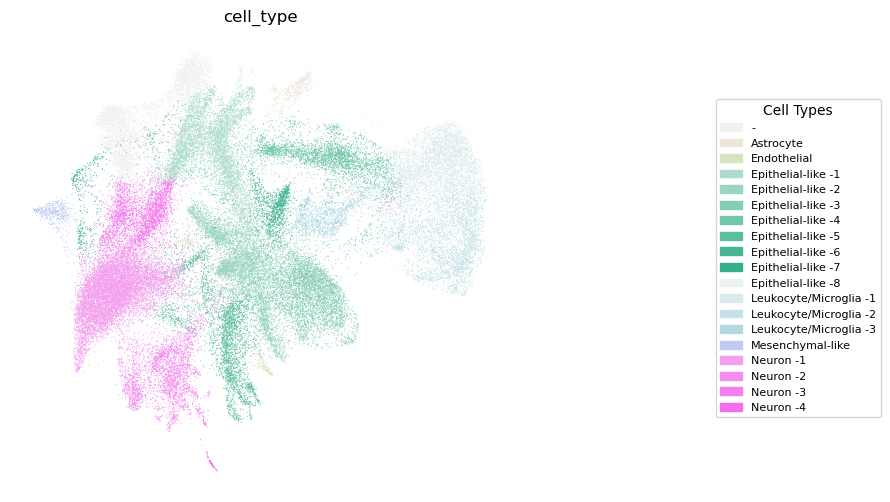

In [11]:
import re

# Choose a scientific-friendly palette ("Set2", "Paired", "Dark2", "husl", "tab20")
PALETTE_NAME = "husl"  # Change this if needed

# Extract the prefix from each cell type
def extract_prefix(cell_type):
    match = re.match(r"^[A-Za-z\-]+", cell_type)
    return match.group() if match else cell_type  # Use full name if no prefix found

# Get all unique prefixes
cell_types = octo_brain.obs["cell_type"].cat.categories
unique_prefixes = sorted(set(extract_prefix(cell) for cell in cell_types))

# Automatically generate distinct colors for each prefix
num_prefixes = len(unique_prefixes)
base_colors = sns.color_palette(PALETTE_NAME, num_prefixes)

# Assign base colors to each prefix
prefix_to_color = {prefix: base_colors[i] for i, prefix in enumerate(unique_prefixes)}

# Assign subtypes a variation of their base color
prefix_shades = {prefix: sns.light_palette(prefix_to_color[prefix], n_colors=10) for prefix in unique_prefixes}

# Map each cell type to a color
cell_type_colors = {cell: prefix_shades[extract_prefix(cell)][i % 10] for i, cell in enumerate(cell_types)}

# Apply new colors to Scanpy
octo_brain.uns["cell_type_colors"] = [cell_type_colors[cell] for cell in cell_types]

# Plot UMAP with updated colors
fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.umap(octo_brain, color="cell_type", ax=ax, frameon=False, show=False, legend_loc=None)

# Sort legend items by prefix, but only display cell types (no prefix label)
sorted_cell_types = sorted(cell_types, key=lambda x: (extract_prefix(x), x))  # Sort by prefix first

legend_elements = [mpatches.Patch(color=cell_type_colors[cell], label=cell) for cell in sorted_cell_types]

# Place legend outside the plot
fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5), title="Cell Types", fontsize=8)
plt.subplots_adjust(right=0.75)
plt.show()

In [12]:
#xlabel: human homolog genes
def plot_genes(human_neurotransmitter_genes, human_to_octo, octo_brain):
    """
    Maps neurotransmitter-related human genes to octopus homologs and generates a dot plot.
    This version updates the x-axis labels to show human homolog names.

    Parameters:
    - human_neurotransmitter_genes: Dictionary mapping neurotransmitter systems to human gene lists.
    - human_to_octo: Dictionary mapping human genes to octopus homologs.
    - octo_brain: AnnData object containing octopus gene expression data.
    """

    mapped_neurotransmitter_genes = {}  # Dictionary to store mapped genes (system → found octo_genes)
    missing_genes = {}  # Store missing genes

    for system, human_genes in human_neurotransmitter_genes.items():
        found_genes = []
        not_found_genes = []
        
        for human_gene in human_genes:
            
            oct_names = human_to_octo.get(human_gene, None)

            if oct_names is None:
                print(f"⚠️ Warning: {human_gene} not found in human_to_octo mapping.")
                not_found_genes.append(human_gene)
                continue

            # Ensure oct_names is always a list
            oct_names = [oct_names] if isinstance(oct_names, str) else oct_names

            # Filter for genes that exist in octo_brain.var_names
            valid_oct_genes = [gene for gene in oct_names if gene in octo_brain.var_names]
            missing_oct_genes = [gene for gene in oct_names if gene not in octo_brain.var_names]

            if valid_oct_genes:
                found_genes.extend(valid_oct_genes)
            if missing_oct_genes:
                missing_genes[human_gene] = missing_oct_genes

        if found_genes:
            mapped_neurotransmitter_genes[system] = found_genes

    # Print summary of found and missing genes
    print("\n **Mapped and Found Genes (Plotted):**")
    for system, genes in mapped_neurotransmitter_genes.items():
        print(f"  - {system}: {', '.join(genes)}")

    if missing_genes:
        print("\n⚠️ **Missing or Not Found in octo_brain.var_names:**")
        for human_gene, oct_genes in missing_genes.items():
            print(f"  - {human_gene} → {', '.join(oct_genes)} (Not Found)")

    # Get unique cell types
    unique_cell_types = octo_brain.obs["cell_type"].unique().tolist()

    # Extract prefixes (e.g., "Neuron", "Contractile") and sort accordingly
    def extract_prefix(cell_type):
        match = re.match(r"([A-Za-z\-]+)", cell_type)  # Match non-numeric prefix
        return match.group(1) if match else cell_type

    sorted_cell_types = sorted(unique_cell_types, key=extract_prefix)
    
    
    # Generate dot plot only if valid genes are found
    if mapped_neurotransmitter_genes:
        sc.pl.dotplot(
            octo_brain, 
            var_names=mapped_neurotransmitter_genes, 
            groupby="cell_type",  # Use cell types instead of cluster numbers
            standard_scale="var", 
            cmap="Reds", 
            figsize=(12, 6),
            categories_order=sorted_cell_types,  # Ensure similar clusters are together
            show=False, 
        )
        
        fig = plt.gcf()
        ax = fig.axes[0]
        
        octo_gene_labels = [label.get_text() for label in ax.get_xticklabels()]
        human_homolog_labels = []
        for gene in octo_gene_labels:
            if gene in octo_brain.var.index:
                homolog = octo_brain.var.loc[gene, 'human_homolog']
                # If homolog is missing or NaN, default to the octopus gene name
                human_homolog_labels.append(homolog if pd.notnull(homolog) else gene)
            else:
                human_homolog_labels.append(gene)
    
        ax.set_xticks(np.arange(len(octo_gene_labels)) + 0.5)
        ax.set_xticklabels(human_homolog_labels, rotation=90, fontsize=8)
        plt.show()
        print("octo_gene_labels List:", octo_gene_labels)
        print("octo_gene_labels shape:", len(octo_gene_labels))
        print("human_homolog_labels:", human_homolog_labels)
        print("human_homolog_labels shape:", len(human_homolog_labels))



⚠️ Warning: IBA1 not found in human_to_octo mapping.

 **Mapped and Found Genes (Plotted):**
  - Astrocyte: Ocbimv22030383m, Ocbimv22014899m, Ocbimv22011933m, Ocbimv22004908m
  - Endothelial: Ocbimv22038765m, Ocbimv22035696m, Ocbimv22039269m, Ocbimv22028138m, Ocbimv22025100m, Ocbimv22038019m
  - Epithelial-like: Ocbimv22013879m, Ocbimv22020641m, Ocbimv22020643m, Ocbimv22013883m, Ocbimv22024371m
  - Leukocyte/Microglia: Ocbimv22029165m, Ocbimv22011288m, Ocbimv22025809m, Ocbimv22023633m, Ocbimv22014986m, Ocbimv22025211m, Ocbimv22023078m, Ocbimv22031750m, Ocbimv22008510m, Ocbimv22013232m, Ocbimv22023008m, Ocbimv22009850m
  - Mesenchymal-like: Ocbimv22013485m, Ocbimv22033024m, Ocbimv22009997m, Ocbimv22013487m, Ocbimv22004908m, Ocbimv22022517m, Ocbimv22022518m, Ocbimv22017255m
  - Neuron: Ocbimv22028847m, Ocbimv22021175m, Ocbimv22013432m, Ocbimv22008684m, Ocbimv22011232m, Ocbimv22013432m, Ocbimv22015129m, Ocbimv22028847m, Ocbimv22011232m, Ocbimv22028489m

⚠️ **Missing or Not Found in octo_b

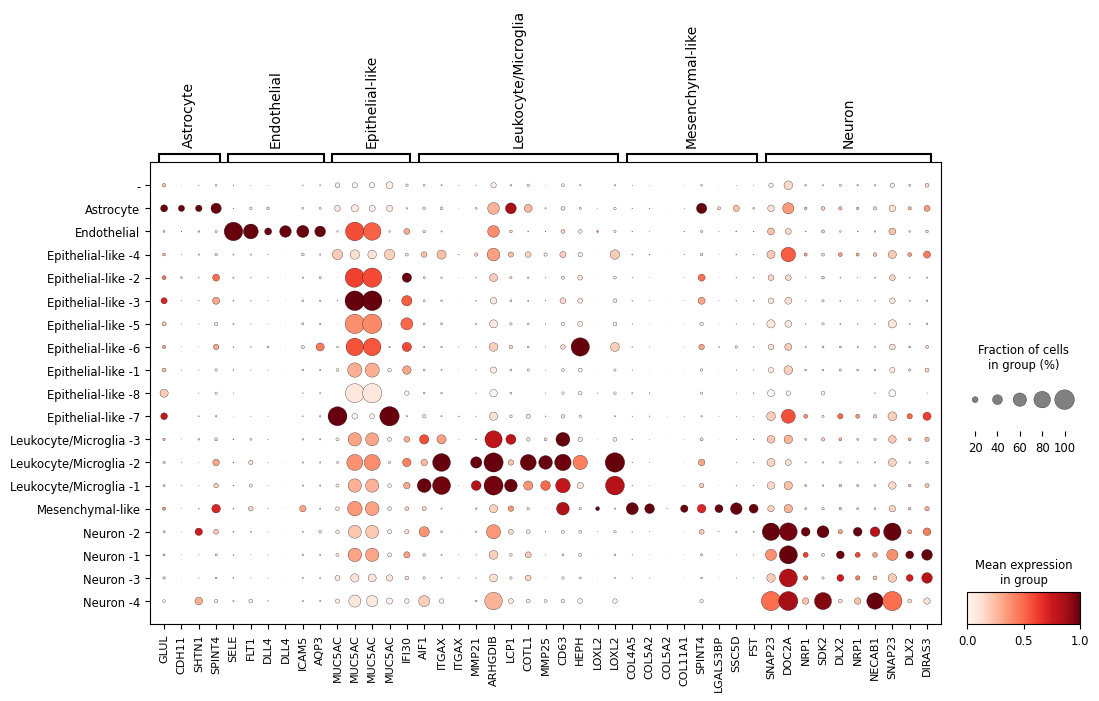

octo_gene_labels List: ['Ocbimv22030383m', 'Ocbimv22014899m', 'Ocbimv22011933m', 'Ocbimv22004908m', 'Ocbimv22038765m', 'Ocbimv22035696m', 'Ocbimv22039269m', 'Ocbimv22028138m', 'Ocbimv22025100m', 'Ocbimv22038019m', 'Ocbimv22013879m', 'Ocbimv22020641m', 'Ocbimv22020643m', 'Ocbimv22013883m', 'Ocbimv22024371m', 'Ocbimv22029165m', 'Ocbimv22011288m', 'Ocbimv22025809m', 'Ocbimv22023633m', 'Ocbimv22014986m', 'Ocbimv22025211m', 'Ocbimv22023078m', 'Ocbimv22031750m', 'Ocbimv22008510m', 'Ocbimv22013232m', 'Ocbimv22023008m', 'Ocbimv22009850m', 'Ocbimv22013485m', 'Ocbimv22033024m', 'Ocbimv22009997m', 'Ocbimv22013487m', 'Ocbimv22004908m', 'Ocbimv22022517m', 'Ocbimv22022518m', 'Ocbimv22017255m', 'Ocbimv22028847m', 'Ocbimv22021175m', 'Ocbimv22013432m', 'Ocbimv22008684m', 'Ocbimv22011232m', 'Ocbimv22013432m', 'Ocbimv22015129m', 'Ocbimv22028847m', 'Ocbimv22011232m', 'Ocbimv22028489m']
octo_gene_labels shape: 45
human_homolog_labels: ['GLUL', 'CDH11', 'SHTN1', 'SPINT4', 'SELE', 'FLT1', 'DLL4', 'DLL4', 'IC

In [17]:
type_marker_genes = {
    "Astrocyte": ["GLUL", "AQP4", "CDH11", "SHTN1", "SPINT4"],
    "Endothelial": ["SELE", "FLT1", "DLL4", "ICAM5", "AQP3"],
    "Epithelial-like": ["MUC5AC", "IFI30"],
    "Leukocyte/Microglia": ["AIF1", "IBA1", "ITGAX", "MMP21", "ARHGDIB", "LCP1", "COTL1", "MMP25", "CD63", "HEPH", "LOXL2"],
    "Mesenchymal-like": ["COL4A5", "COL5A2", "COL11A1", "SPINT4", "LGALS3BP", "SSC5D", "FST"],
    "Neuron": ["SNAP23", "DOC2A", "NRP1", "SDK2", "DLX2", "NRP1", "NECAB1", "SNAP23", "DLX2", "DIRAS3"],
}

# Run the function
plot_genes(type_marker_genes, human_to_octo, octo_brain)


⚠️ Warning: GABRA4 not found in human_to_octo mapping.
⚠️ Warning: GABRA5 not found in human_to_octo mapping.
⚠️ Warning: GABRB1 not found in human_to_octo mapping.
⚠️ Warning: GABRE not found in human_to_octo mapping.
⚠️ Warning: GAD2 not found in human_to_octo mapping.
⚠️ Warning: SLC6A9 not found in human_to_octo mapping.
⚠️ Warning: GLRA1 not found in human_to_octo mapping.
⚠️ Warning: GLRA2 not found in human_to_octo mapping.
⚠️ Warning: GLRA3 not found in human_to_octo mapping.
⚠️ Warning: GLRA4 not found in human_to_octo mapping.
⚠️ Warning: GLYATL1 not found in human_to_octo mapping.
⚠️ Warning: GLYATL2 not found in human_to_octo mapping.
⚠️ Warning: GRIA3 not found in human_to_octo mapping.
⚠️ Warning: GRIN2A not found in human_to_octo mapping.
⚠️ Warning: GRIN2C not found in human_to_octo mapping.
⚠️ Warning: GRIN2D not found in human_to_octo mapping.
⚠️ Warning: GRIK4 not found in human_to_octo mapping.
⚠️ Warning: SLC1A2 not found in human_to_octo mapping.
⚠️ Warning: SLC1A

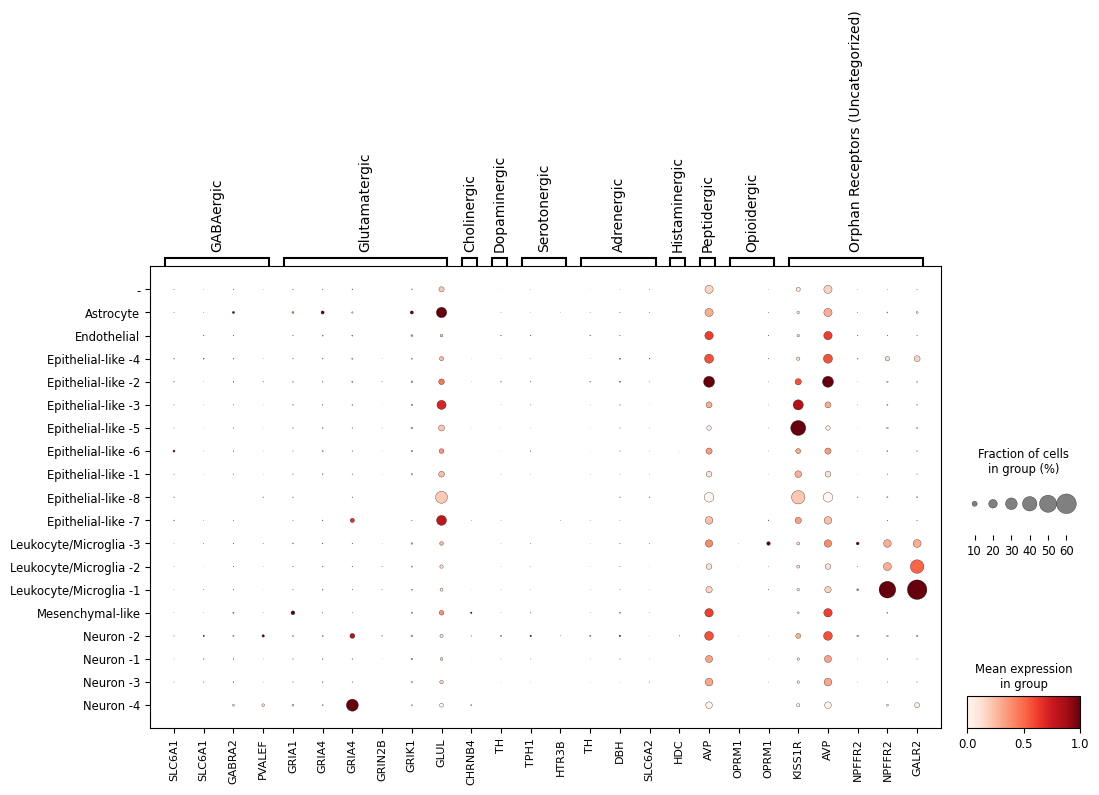

octo_gene_labels List: ['Ocbimv22022648m', 'Ocbimv22026818m', 'Ocbimv22034660m', 'Ocbimv22010711m', 'Ocbimv22039455m', 'Ocbimv22034717m', 'Ocbimv22003892m', 'Ocbimv22018191m', 'Ocbimv22039454m', 'Ocbimv22030383m', 'Ocbimv22017869m', 'Ocbimv22029695m', 'Ocbimv22017369m', 'Ocbimv22032607m', 'Ocbimv22029695m', 'Ocbimv22031264m', 'Ocbimv22007737m', 'Ocbimv22019847m', 'Ocbimv22009174m', 'Ocbimv22022447m', 'Ocbimv22013365m', 'Ocbimv22009073m', 'Ocbimv22009174m', 'Ocbimv22033338m', 'Ocbimv22001500m', 'Ocbimv22017246m']
octo_gene_labels shape: 26
human_homolog_labels: ['SLC6A1', 'SLC6A1', 'GABRA2', 'PVALEF', 'GRIA1', 'GRIA4', 'GRIA4', 'GRIN2B', 'GRIK1', 'GLUL', 'CHRNB4', 'TH', 'TPH1', 'HTR3B', 'TH', 'DBH', 'SLC6A2', 'HDC', 'AVP', 'OPRM1', 'OPRM1', 'KISS1R', 'AVP', 'NPFFR2', 'NPFFR2', 'GALR2']
human_homolog_labels shape: 26


In [18]:
# Human homologs of neurotransmitter genes
human_neurotransmitter_genes = {
    "GABAergic": [
        "SLC6A1", "SLC32A1", "SLC6A11", "SLC6A12",  # GABA transporters
        "GABRA1", "GABRA2", "GABRA3", "GABRA4", "GABRA5", "GABRA6",  # GABA-A receptors
        "GABRB1", "GABRB2", "GABRB3", "GABRD", "GABRE", "GABRP", "GABRQ",  # GABA-B receptors
        "GABBR1", "GABBR2", "ABAT", "GAD1", "GAD2",  # GABA metabolism
        "PVALEF"
    ],
    "Glycinergic": [
        "SLC6A5", "SLC6A9",  # Glycine transporters
        "GLRA1", "GLRA2", "GLRA3", "GLRA4", "GLRB",  # Glycine receptors
        "GLYCTK", "GLYATL1", "GLYATL2"  # Glycine metabolism
    ],
    "Glutamatergic": [
        "GRIA1", "GRIA2", "GRIA3", "GRIA4",  # AMPA receptors
        "GRIN1", "GRIN2A", "GRIN2B", "GRIN2C", "GRIN2D",  # NMDA receptors
        "GRIK1", "GRIK2", "GRIK3", "GRIK4", "GRIK5",  # Kainate receptors
        "SLC1A2", "SLC1A3", "SLC1A6", "SLC1A7",  # Glutamate transporters
        "GLS", "GLUL",  # Glutamate metabolism
        "GRM1", "GRM2", "GRM3", "GRM4", "GRM5", "GRM6", "GRM7", "GRM8"  # Metabotropic glutamate receptors
    ],
    "Cholinergic": [
        "CHRNA1", "CHRNA2", "CHRNA3", "CHRNA4", "CHRNA5", "CHRNA6", "CHRNA7", "CHRNA9", "CHRNA10",  # Nicotinic receptors
        "CHRNB1", "CHRNB2", "CHRNB3", "CHRNB4",  # Nicotinic receptors beta subunits
        "CHRM1", "CHRM2", "CHRM3", "CHRM4", "CHRM5",  # Muscarinic receptors
        "ACHE", "BCHE", "SLC18A3", "CHAT"  # Choline metabolism and transport
    ],
    "Dopaminergic": [
        "TH", "DDC",  # Dopamine synthesis
        "SLC6A3", "SLC18A2",  # Dopamine transporters
        "DRD1", "DRD2", "DRD3", "DRD4", "DRD5",  # Dopamine receptors
        "COMT", "MAOA", "MAOB"  # Dopamine metabolism
    ],
    "Serotonergic": [
        "TPH1", "TPH2", "DDC",  # Serotonin synthesis
        "SLC6A4", "SLC18A2",  # Serotonin transporters
        "HTR1A", "HTR1B", "HTR1D", "HTR1E", "HTR1F", "HTR2A", "HTR2B", "HTR2C", "HTR3A", "HTR3B",
        "HTR4", "HTR5A", "HTR5B", "HTR6", "HTR7",  # Serotonin receptors
        "MAOA", "MAOB"  # Serotonin metabolism
    ],
    "Adrenergic": [
        "TH", "DBH", "PNMT",  # Catecholamine synthesis
        "SLC6A2",  # Norepinephrine transporter
        "ADRA1A", "ADRA1B", "ADRA1D", "ADRA2A", "ADRA2B", "ADRA2C", "ADRB1", "ADRB2", "ADRB3"  # Adrenergic receptors
    ],
    "Histaminergic": [
        "HDC",  # Histamine synthesis
        "HRH1", "HRH2", "HRH3", "HRH4",  # Histamine receptors
        "SLC18A2", "HNMT"  # Histamine transport and metabolism
    ],
    "Purinergic (ATP/ADP receptors)": [
        "P2RX7"  # ATP-gated ion channels
    ],
    "Peptidergic": [
        "POMC", "NPY", "GAL", "CARTPT", "TRH", "CRH", "AVP", "OXT", "VIP", "PACAP", "NPFF", "NMU", "PTH2R",  # Neuropeptides
        "PCSK1", "PCSK2"  # Neuropeptide processing
    ],
    "Endocannabinoid": [
        "CNR1", "CNR2", "FAAH", "MGLL", "NAPEPLD", "DAGLA", "DAGLB",  # Endocannabinoid metabolism and receptors
        "ABHD6", "ABHD12"  # Enzymes involved in degradation
    ],
    "Opioidergic": [
        "OPRM1", "OPRD1", "OPRK1", "OPRX",  # Opioid receptors
        "PENK", "PDYN", "POMC", "PNOC"  # Opioid peptides
    ],
    "Gasotransmitters": [
        "NOS1", "NOS2", "NOS3", "HO1", "HO2", "CSE"  # Nitric oxide, carbon monoxide, and hydrogen sulfide signaling
    ],
    "Orphan Receptors (Uncategorized)": [
        "KISS1R", "AVP", "NPFFR2", "GALR2"  # Neuroendocrine and orphan receptors not fitting a single category
    ]
}



# Run the function
plot_genes(human_neurotransmitter_genes, human_to_octo, octo_brain)

⚠️ Warning: OR2W1 not found in human_to_octo mapping.
⚠️ Warning: OR4C11 not found in human_to_octo mapping.
⚠️ Warning: OR5A1 not found in human_to_octo mapping.
⚠️ Warning: OR6A2 not found in human_to_octo mapping.
⚠️ Warning: OR10J1 not found in human_to_octo mapping.
⚠️ Warning: OR52E4 not found in human_to_octo mapping.
⚠️ Warning: OR51E1 not found in human_to_octo mapping.
⚠️ Warning: OR56A4 not found in human_to_octo mapping.
⚠️ Warning: OR2AG1 not found in human_to_octo mapping.
⚠️ Warning: OR4C3 not found in human_to_octo mapping.
⚠️ Warning: OR7D4 not found in human_to_octo mapping.
⚠️ Warning: OR1A1 not found in human_to_octo mapping.
⚠️ Warning: CNGA4 not found in human_to_octo mapping.
⚠️ Warning: GNAL not found in human_to_octo mapping.
⚠️ Warning: GNG13 not found in human_to_octo mapping.
⚠️ Warning: GNAT3 not found in human_to_octo mapping.
⚠️ Warning: TMC2 not found in human_to_octo mapping.
⚠️ Warning: POU4F3 not found in human_to_octo mapping.
⚠️ Warning: CABP2 not f

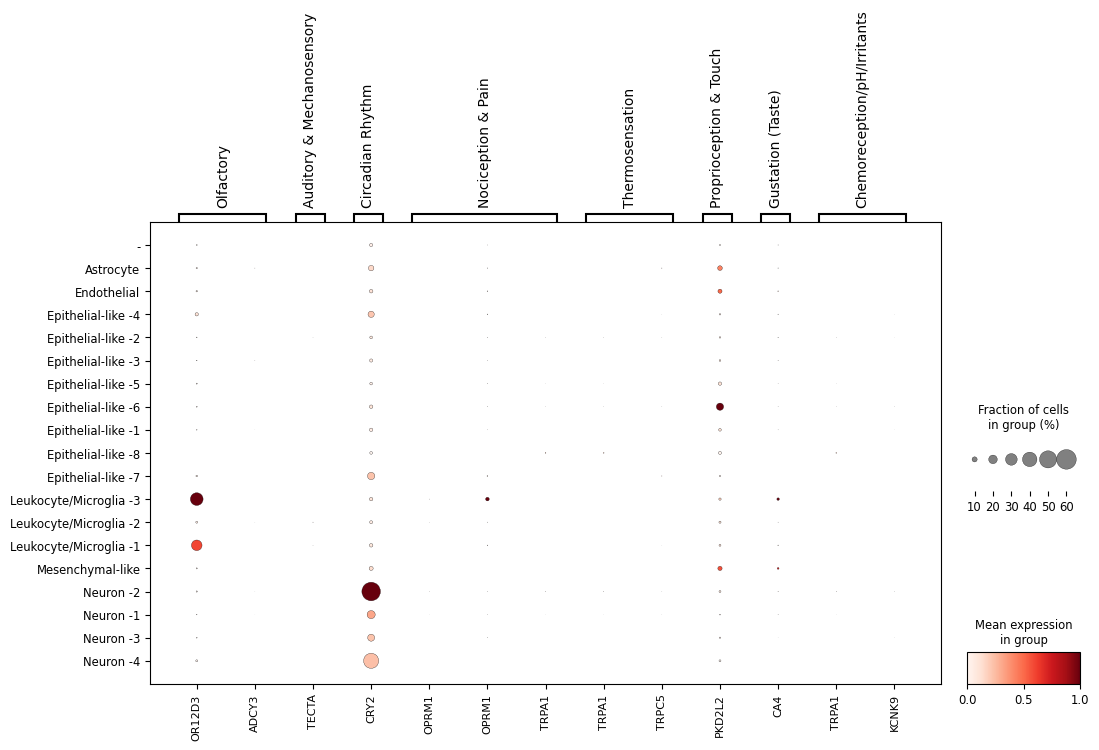

octo_gene_labels List: ['Ocbimv22011018m', 'Ocbimv22022763m', 'Ocbimv22004093m', 'Ocbimv22020128m', 'Ocbimv22022447m', 'Ocbimv22013365m', 'Ocbimv22004855m', 'Ocbimv22004855m', 'Ocbimv22020009m', 'Ocbimv22003714m', 'Ocbimv22023623m', 'Ocbimv22004855m', 'Ocbimv22000601m']
octo_gene_labels shape: 13
human_homolog_labels: ['OR12D3', 'ADCY3', 'TECTA', 'CRY2', 'OPRM1', 'OPRM1', 'TRPA1', 'TRPA1', 'TRPC5', 'PKD2L2', 'CA4', 'TRPA1', 'KCNK9']
human_homolog_labels shape: 13


In [19]:
human_sensory_genes = {
    "Olfactory": [
        "OR12D3", "OR2W1", "OR4C11", "OR5A1", "OR6A2", "OR10J1", "OR52E4",  # Olfactory receptor genes
        "OR51E1", "OR56A4", "OR2AG1", "OR4C3", "OR7D4", "OR1A1",  # Additional key olfactory receptors
        "ADCY3", "CNGA2", "CNGA4", "CNGB1",  # Olfactory signal transduction pathway
        "GNAL", "GNG13", "GNAT3"  # Olfactory G-protein subunits
    ],  
    "Auditory & Mechanosensory": [
        "TECTA", "TMC1", "TMC2", "POU4F3", "MYO7A", "ESPN", "CABP2", "LOXHD1",  # Inner ear and mechanosensory genes
        "SLC26A4", "USH1C", "PDZD7", "DFNB31", "HGFAC", "MYO6", "MYO15A",  # Additional auditory-related genes
        "OTOF", "OTOG", "STRC", "GJB2", "GJB6",  # Hearing-related mutations (deafness genes)
        "PKD1L1"
    ],  
    "Visual": [
        "RHO", "OPN1LW", "OPN1MW", "OPN1SW", "GUCY2D", "PDE6A", "PDE6B", "CNGA1", "CNGB1",  # Rod and cone function
        "GNAT1", "GNAT2", "ARR3", "OPN3", "OPN4", "PDC",  # Additional phototransduction genes
        "BEST1", "VSX2", "CRX", "NR2E3", "RPGR", "LRAT", "RLBP1",  # Retinal development and degeneration
        "RDH12", "RDH5", "ABCA4", "SAG", "ROM1", "PRPH2",  # Additional vision-related genes
        "OPN3"
    ],  
    "Circadian Rhythm": [
        "MTNR1A", "MTNR1B", "CLOCK", "ARNTL", "PER1", "PER2", "PER3", "CRY1", "CRY2",  # Core clock genes
        "NR1D1", "NR1D2", "RORA", "RORB", "RORG",  # Additional circadian regulatory genes
        "BHLHE40", "BHLHE41", "DBP", "TEF", "DEC1", "DEC2",  # Circadian transcription factors
    ],  
    "Nociception & Pain": [
        "OPRL1", "OPRM1", "SCN9A", "SCN10A", "SCN11A", "TRPV1", "TRPA1", "ASIC3", "P2RX3", "CALCA",  # Pain transduction
        "SCN8A", "P2RX4", "P2RX7", "NGF", "NTRK1", "GFRAL",  # Additional pain-associated genes
        "NAV1.7", "NAV1.8", "NAV1.9", "TNFRSF1A", "SPTA1"  # Neuropathic pain and nociceptors
    ],  
    "Thermosensation": [
        "TRPM8", "TRPV3", "TRPV4", "TRPV1", "KCNN3",  # Core thermosensors
        "TRPA1", "TRPC5", "TRPV2", "TRPV8",  # Additional TRP channels for temperature sensing
        "SCN3A", "SCN5A", "SLC17A8", "KCNK4", "HCN2"  # Ion channels involved in temperature adaptation
    ],  
    "Proprioception & Touch": [
        "PIEZO1", "PIEZO2", "SCN9A", "SCN10A", "SCN11A", "PKD2L1", "TRPC6", "ASIC2",  # Core mechanosensation genes
        "PIEZO3", "PKD1L2", "PKD1L3", "PKD2L2", "STOML3",  # Additional proprioceptors and mechanoreceptors
        "GPR126", "GPR68", "GPR132", "ANO1", "ANO3"  # Mechanosensitive G-protein receptors
    ],  
    "Electroreception": [
        "SCN4B", "KCNJ10", "KCNA7", "CACNA1G",  # Core genes in weakly electric fish electroreception
        "SCN1B", "SCN2B", "SCN3B", "SCN5A", "KCNA4", "KCNA6"  # Additional ion channels involved in electro-sensing
    ],  
    "Magnetoreception": [
        "MAGR", "CRY4", "FAD", "NPAS2",  # Primary candidates for vertebrate magnetoreception
        "OPN5", "CRY1A", "CRY2A", "PER2B", "BHLHE42"  # Additional circadian-magnetic field-linked genes
    ],  
    "Gustation (Taste)": [
        "TAS1R1", "TAS1R2", "TAS1R3", "TAS2R1", "TAS2R3", "TAS2R4", "TAS2R5", "TAS2R16", "GNAT3", "PKD2L1",  # Core taste receptors
        "TAS2R38", "TAS2R46", "TAS2R50", "TAS2R60", "TAS2R19", "TAS2R40", "TAS2R42",  # Bitter taste receptor expansion
        "CA6", "CA4", "TRPM5", "TRPV1", "ENaC", "SCNN1A", "SCNN1B", "SCNN1G"  # Salt, sour, and general taste-related genes
    ],  
    "Chemoreception/pH/Irritants": [
        "GPR4", "TASK2", "ASIC1", "SLC4A1", "TRPA1", "OLFR78", "CAR2",  # CO₂/O₂ sensing and irritant response
        "SLC9A1", "SLC9A3", "SLC4A7", "GPR65", "GPR68", "GPRC5B",  # Additional chemosensors for acid/base balance
        "KCNK3", "KCNK9", "KCNK10", "KCNK13", "KCNK18"  # Potassium channels involved in pH/chemical detection
    ]
}

# Run the function
plot_genes(human_sensory_genes, human_to_octo, octo_brain)

In [171]:
df = pd.DataFrame(list(human_to_octo.items()), columns=["human_gene", "octo_gene"])
df.to_csv("human_to_octo.csv", index=False)